Load data

Average height difference 0.49347395920816034
Average sum distance is 16.177716714143244


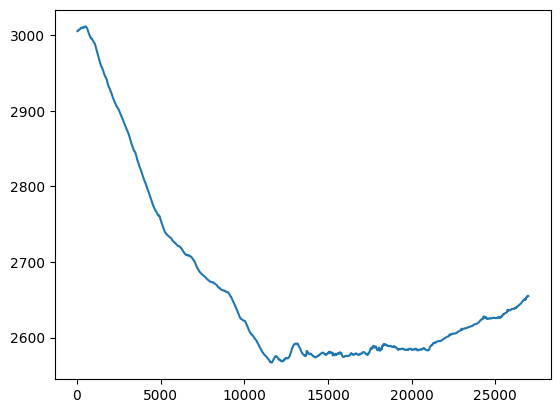

0.13951587677001953 ms


In [2]:
#add libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm
import time as time
start = time.time()
#add data
datos = pd.read_csv("datasets/Viajes MEX-TOL.csv")
#convert to utm
latitudes = np.array(datos["latitud"])
longitudes = np.array(datos["longitud"])
utms = utm.from_latlon(latitudes,longitudes,14,"Q") #14Q for Mexico
datos_f = datos.copy()
datos_f["utm_x"] = utms[0]
datos_f["utm_y"] = utms[1]


min_longitud = -99.64
max_longitud = -99.39
datos_f = datos_f[datos_f['longitud'] > min_longitud]
datos_f = datos_f[datos_f['longitud'] < max_longitud]
datos_f = datos_f[datos_f['longitud'] < max_longitud]
datos_f = datos_f.reset_index()

datos_f = datos_f.drop(["l","latitud","longitud","fecha","hora"],axis=1)
datos_f = datos_f.rename(columns={"altitud": "height"})
#lag point coordinates
datos_l = datos_f.copy()
datos_l["next_utm_x"] = datos_f["utm_x"].shift(-1)
datos_l["next_utm_y"] = datos_f["utm_y"].shift(-1)
datos_l["next_height"] = datos_f["height"].shift(-1)
print('Average height difference',abs(datos_l["next_height"] - datos_l["height"]).mean())

#calculate distances and slopes
datos_l["distance"] = np.sqrt((datos_l["utm_x"]-datos_l["next_utm_x"])**2 + (datos_l["utm_y"]-datos_l["next_utm_y"])**2)
datos_l["slope"] = (datos_l["next_height"]-datos_l["height"])/datos_l["distance"] 
datos_l["sum_distance"] = np.cumsum(datos_l["distance"])
print("Average sum distance is",datos_l['distance'].mean())
plt.plot(datos_l["sum_distance"],datos_l["height"])
plt.show()    
datos_l.head(10)
stop = time.time()
datos_l = datos_l[:-1]
print(stop-start,"ms")

Clustering

In [3]:
import seaborn as sns

In [4]:
def sdd_clust(data, tol):
    heights = data["height"]
    clusters = np.ones(len(heights))
    sdd_cluster=1
    dist = 0
    for i in range(1,len(heights)-1):
        dist = abs(heights[i-1]-heights[i])
        if dist>tol:
            sdd_cluster = sdd_cluster+1
        clusters[i] = sdd_cluster  

    data["cluster"] = clusters    
    return data

In [5]:
def tol_adjust (data, tol=1.6):
  n = 1
  while n>0 :
    tol = tol + 0.1
    data2 = sdd_clust(data, tol)
    frec = data2.cluster.value_counts().to_numpy()
    n = frec[frec==1].shape[0] #number of one-single-point clusters
  print('Min gap distance',tol)
  return data2
   


Min gap distance 2.600000000000001


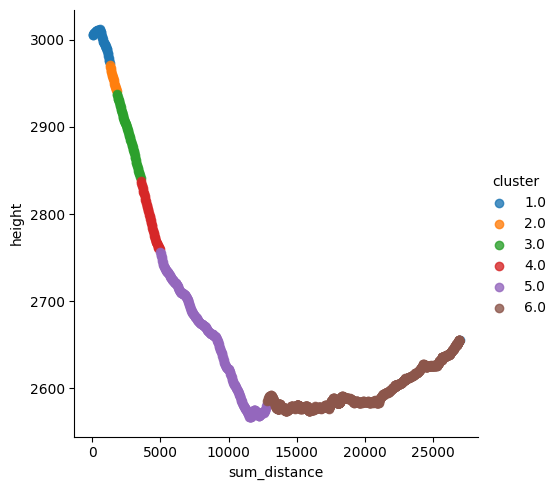

In [6]:
data_clustered = tol_adjust(datos_l, 1.6)

sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered.drop(['next_utm_x','next_utm_y', 'next_height', 'index' ], axis=1)
data_clustered = data_clustered.reset_index(drop=True)



In [8]:
from sklearn.linear_model import LinearRegression
import math

def height_correction(data_clustered, max_points=5,max_distance=0.5):
    clusters = data_clustered.cluster.unique()
    if(len(clusters)>1):
        gps_smooth = pd.DataFrame()
        for i in range(1,len(clusters)):
            #take pair of clusters
            grupo1 = data_clustered[data_clustered['cluster']==i].copy()
            grupo2 = data_clustered[data_clustered['cluster']==(i+1)].copy()
            m = np.min([grupo1.shape[0],grupo2.shape[0],max_points])

            #take last and first m points  (important to not include borders which are outliers)
            subgrupo1 = grupo1[:-1].tail(m)
            subgrupo2 = grupo2.iloc[2:m]

    
            r = pd.concat([subgrupo1,subgrupo2]).reset_index(drop=True)
            modelo_z = LinearRegression().fit(r[['sum_distance']],r[['height']])
            modelo_x = LinearRegression().fit(r[['sum_distance']],r[['utm_x']])
            modelo_y = LinearRegression().fit(r[['sum_distance']],r[['utm_y']])
            
            #200 -100 /5
            #100 200:  100 120 140 160 180 200
            #reemplazar con suavizado
            x_min = r.sum_distance.min()
            x_max = r.sum_distance.max()
            replace_points = math.ceil((r.sum_distance.max()-r.sum_distance.min())/max_distance)

            gap_points = pd.DataFrame({'sum_distance':np.linspace(r.sum_distance.min(),r.sum_distance.max(),replace_points)})

            h_smooth = modelo_z.predict(gap_points[['sum_distance']])                          
            gap_points['height']=h_smooth         
            x_smooth = modelo_x.predict(gap_points[['sum_distance']])
            gap_points['utm_x']=x_smooth
            y_smooth = modelo_y.predict(gap_points[['sum_distance']])
            gap_points['utm_y']=y_smooth
            gap_points['secuencia']=0
            gap_points['distance']=0
            gap_points['slope']=0
            gap_points['cluster']=0
            if i==1:
                gps_smooth = pd.concat([gps_smooth,grupo1[0:(grupo1.shape[0] - (m+1))],gap_points])    
            else: 
                gps_smooth = pd.concat([gps_smooth,grupo1[m:(grupo1.shape[0] - (m+1))],gap_points])    
        gps_smooth = pd.concat([gps_smooth,  grupo2[m:(grupo2.shape[0] - (m+1))]])
  
    else:
        print("WARNING: No gaps found (clusters number must be longer than 1")
    datos_l = gps_smooth.copy()
    datos_l["next_utm_x"] = datos_l["utm_x"].shift(-1)
    datos_l["next_utm_y"] = datos_l["utm_y"].shift(-1)
    datos_l["next_height"] = datos_l["height"].shift(-1)
    #calculate distances and slopes
    datos_l["distance"] = np.sqrt((datos_l["utm_x"]-datos_l["next_utm_x"])**2 + (datos_l["utm_y"]-datos_l["next_utm_y"])**2)
    datos_l["slope"] = (datos_l["next_height"]-datos_l["height"])/datos_l["distance"] 
    datos_l["sum_distance"] = np.cumsum(datos_l["distance"])
    return(datos_l.reset_index(drop=True))

Min gap distance 2.1000000000000005


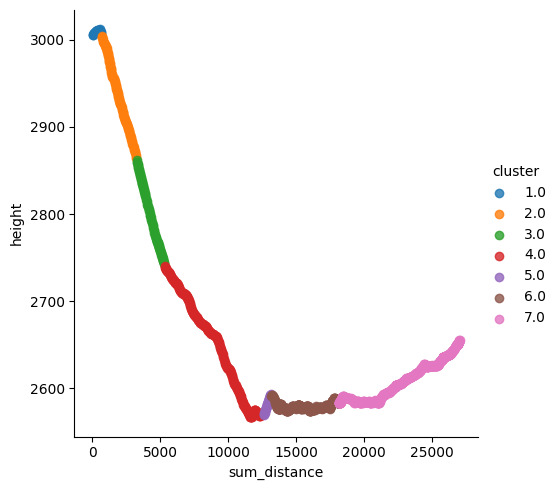

In [9]:
data_smooth = height_correction(data_clustered,10,17)
data_clustered = tol_adjust(data_smooth, 1.6)
sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered.reset_index(drop=True)


Min gap distance 2.1000000000000005
Min gap distance 2.1000000000000005


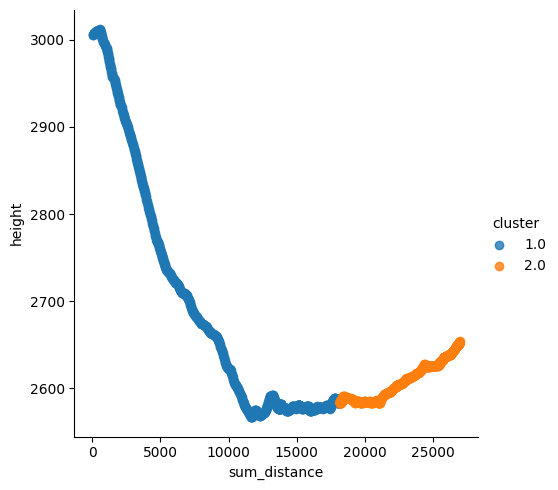

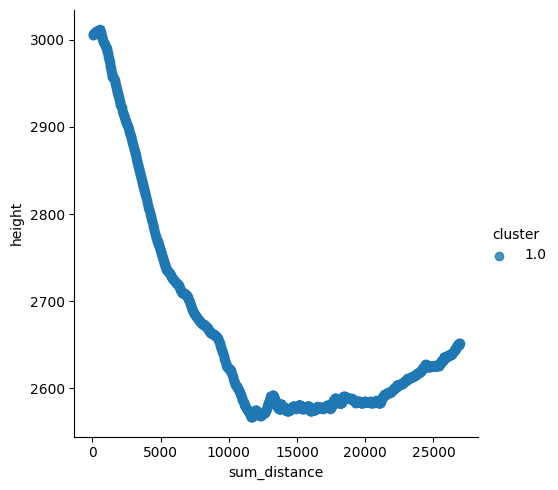

In [10]:
#experimento iterativo, clusterizar -> corregir -> clusterizar -> corregir ....
while len(data_clustered.cluster.unique())>1:
    data_smooth = height_correction(data_clustered,5,17)
    data_clustered = tol_adjust(data_smooth, 1.6)
    sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
    data_clustered = data_clustered.reset_index(drop=True)